## 1 Library Import
- 필요한 라이브러리를 불러옵니다.

In [3]:
# !pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import lightgbm as lgb

# tuning
from datetime import datetime
from functools import partial
import optuna


pd.set_option('display.max_columns', None)

In [5]:
logTarget = False
logArea = True

## 2 Data Load

In [6]:
folder = 'data/'
dt = pd.read_csv(folder+'train.csv')
dt_test = pd.read_csv(folder+'test.csv')

## 3 Data Processing

### 3.1 Data Preprocessing

In [7]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1

concat = pd.concat([dt, dt_test]).reset_index(drop=True)     # 하나의 데이터로 만들어줍니다.

In [8]:
# 컬럼 이름 변경
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [9]:
# 사용하지 않을 컬럼 제거
concat_select = concat.drop(columns=['해제사유발생일', '등기신청일자', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob',
       'k-사용검사일-사용승인일','k-홈페이지','k-등록일자', '고용보험관리번호', '경비비관리형태', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '단지신청일',
       'k-135㎡초과', '관리비 업로드',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-수정일자', '건축면적', 
       ])

In [10]:
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [11]:
def parted_area(x):
    if x <= 40:
        return 0
    elif x <= 60:
        return 1
    elif x <= 85:
        return 2
    elif x <= 135:
        return 3
    else:
        return 4

concat_select['전용면적범주'] = concat_select['전용면적'].apply(parted_area)

### 3.2 외부데이터

#### 3.1.1 금리 데이터

In [12]:
base_df = pd.read_csv(folder+'base_rate.csv')

In [13]:
base_df.drop(columns=['통계표', '단위', '변환'], inplace=True)

base_df.columns = [''.join(x) for x in base_df.columns.str.split('/')]

base_df = pd.melt(base_df, id_vars=['계정항목'], var_name='년월', value_name='금리')
base_df['년월'] = base_df['년월'].astype(np.int32)

base_df = base_df.pivot(index='년월', columns='계정항목', values='금리').reset_index()

base_df = base_df[['년월', '정부대출금금리', '한국은행 기준금리'] ]
base_df.columns = ['계약년월', '대출금리', '기준금리']

# 평가데이터의 금리는 학습데이터 기준 가장 최근과 동일하게 설정
base_df.loc[base_df['계약년월'] > 202306,'대출금리'] = base_df[base_df['계약년월'] == 202306]['대출금리'].iloc[0]
base_df.loc[base_df['계약년월'] > 202306,'기준금리'] = base_df[base_df['계약년월'] == 202306]['기준금리'].iloc[0]

concat_select = concat_select.merge(base_df, how='left', on='계약년월')

#### 3.1.2 아파트 단지 정보 데이터
- 해당 데이터와 train 데이터에서 겹치는 컬럼을 결측치를 채우는데 이용합니다.
- 또한 단지 정보 데이터에서 활용할 수 있는 새로운 컬럼들도 추가해줍니다.

In [14]:
basic_apart = pd.read_parquet(folder+'basic_apart.parquet')

In [15]:
basic_apart = basic_apart[basic_apart['시도'] == '서울특별시']
concat_select['아파트주소'] = concat_select['시군구'] + " " + concat_select['번지']
basic_apart['법정주소'] = basic_apart['법정동주소'].str.split(",").str[0]
basic_apart['아파트주소'] = basic_apart['법정주소'].str.split(" ").str[0:4].apply(lambda x: " ".join(x))

""" 
승강기 갯수에 대한 정보는 '승강기(승객용)', '승강기(화물용)' 컬럼을 합쳐도 승강기(승객+화물)와 다르다거나
'승강기(승객용)', '승강기(화물용)', '승강기(승객+화물)' 컬럼이 모두 0인데 '승강기(장애인)' 컬럼의 승강기 갯수가 높다거나
데이터가 무분별하게 입력돼 있다고 판단하여 가장 큰 값만 가져와 활용합니다.
"""
basic_apart['승강기'] = basic_apart[['승강기(승객용)', '승강기(화물용)', '승강기(승객+화물)','승강기(장애인)', '승강기(비상용)', '승강기(기타)']].max(axis=1)

In [16]:
basic_apart['차량보유대수(전체)'] = basic_apart['차량보유대수(전체)'].astype('Int64')
basic_apart['차량보유대수(전기차)'] = basic_apart['차량보유대수(전기차)'].astype('Int64')

basic_apart['전기차전용주차면수(지상)'] = basic_apart['전기차전용주차면수(지상)'].replace("해당없음", "0")
basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].replace("해당없음", "0")

basic_apart['전기차전용주차면수(지상)'] = basic_apart['전기차전용주차면수(지상)'].astype("Int64")
basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].astype(float)

basic_apart['전기충전기설치여부(지상)'] = basic_apart['전기충전기설치여부(지상)'].map({"해당없음":0, "설치":1}).astype("Int64")
basic_apart['전기충전기설치여부(지하)'] = basic_apart['전기충전기설치여부(지하)'].map({"해당없음":0, "설치":1}).astype("Int64")
basic_apart['전기충전기설치여부'] = basic_apart['전기충전기설치여부(지상)'] | basic_apart['전기충전기설치여부(지하)']

# 전기차전용주차면수(지하) 컬럼 이상치 처리
basic_apart.loc[basic_apart['단지코드'] == "A10023343", '전기차전용주차면수(지하)'] = basic_apart.loc[basic_apart['단지코드'] == "A10023343", '총주차대수']

basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].astype('Int64')
basic_apart['전기차전용주차면수'] = basic_apart['전기차전용주차면수(지상)'] + basic_apart['전기차전용주차면수(지하)']

##### 중복값 처리
아파트단지정보 데이터에서 아파트주소(시군구+번지)를 key값으로 train 데이터와 병합해줄 것이기 때문에 아파트주소가 unique한 값을 가지도록 중복값을 처리합니다.
- case1: 동일한 주소에 다른아파트가 여러개인 경우 => 엉뚱한 데이터가 병합될 위험이 있기 때문에 그냥 제거해줍니다.
- case2: 같은 아파트이지만 분양과 입대에 대한 데이터가 따로 존재하는경우 => 적절한 통계함수를 적용해서 두 데이터를 합쳐줍니다.

In [17]:
basic_du = basic_apart[basic_apart.duplicated(subset='아파트주소', keep=False)]
basic_du['이전분양형태'] = basic_du.groupby('아파트주소')['분양형태'].shift(-1)
basic_du = basic_du[~((basic_du['분양형태'].str.contains("분양|혼합")) & basic_du['이전분양형태'].str.contains("분양|혼합"))]

basic_apart.drop_duplicates(subset='아파트주소', keep=False, inplace=True)

In [18]:
# 사용할 컬럼만 선택합니다.
selected = ['분양형태', '법정주소', '단지명', '동수', '세대수', '분양세대수', '임대세대수', '관리방식', '난방방식', '복도유형', '시공사', '시행사',
'일반관리-관리방식', '일반관리-인원', '경비관리-관리방식', '경비관리-인원', '청소관리-관리방식', '청소관리-인원', '건물구조', '전기-수전용량', '전기-세대전기계약방식',
'승강기', '총주차대수', '지상주차대수', '지하주차대수', 'CCTV대수', '부대복리시설', '최고층수','지하층수', '차량보유대수(전체)',
'차량보유대수(전기차)', '전기충전기설치여부(지상)', '전기충전기설치여부(지하)','전기차전용주차면수(지상)','전기차전용주차면수(지하)', '아파트주소']

In [19]:
# case2에 관하여 어떻게 데이터를 합쳐줄지에 대한 통계함수입니다.
AGGREGATIONS = {
    '분양형태': 'first',
    '법정주소': 'first',
    '단지명': 'first',
    '동수': 'sum',
    '세대수': 'sum',
    '분양세대수': 'sum',
    '임대세대수': 'sum',
    '관리방식': 'first',
    '난방방식': 'first',
    '복도유형': 'first',
    '시공사': 'first',
    '시행사': 'first',
    '일반관리-인원': 'sum',
    '청소관리-인원': 'sum',
    '전기-수전용량': 'sum',
    '전기-세대전기계약방식': 'first',
    '승강기': 'sum',
    '총주차대수': 'sum',
    '지상주차대수': 'sum',
    '지하주차대수': 'sum',
    'CCTV대수': 'sum',
    '부대복리시설': 'first',
    '최고층수': 'max',
    '지하층수': 'max',
    '차량보유대수(전체)': 'sum',
    '차량보유대수(전기차)': 'sum',
    '전기충전기설치여부(지상)': 'max',
    '전기충전기설치여부(지상)': 'max',
    '전기차전용주차면수(지상)': 'sum',
    '전기차전용주차면수(지하)': 'sum',
}

basic_du = basic_du[selected].groupby('아파트주소').agg(AGGREGATIONS).reset_index()
basic_du['분양형태'] = '혼합'

basic_apart = pd.concat([basic_apart, basic_du], axis=0)
concat_merge = concat_select.merge(basic_apart[selected], how='left', on='아파트주소')

##### 결측값 채우기

In [20]:
# 결측값을 채워줄 컬럼들입니다.
['k-세대타입(분양형태)', '분양형태', 
 'k-관리방식', '관리방식',
 'k-복도유형','복도유형', 
 'k-난방방식', '난방방식', 
 'k-전체동수', '동수', 
 'k-전체세대수', '세대수', 
 'k-건설사(시공사)', '시공사', 
 'k-시행사', '시행사', 
 '세대전기계약방법', '전기-세대전기계약방식', 
 '주차대수', '총주차대수',]

['k-세대타입(분양형태)',
 '분양형태',
 'k-관리방식',
 '관리방식',
 'k-복도유형',
 '복도유형',
 'k-난방방식',
 '난방방식',
 'k-전체동수',
 '동수',
 'k-전체세대수',
 '세대수',
 'k-건설사(시공사)',
 '시공사',
 'k-시행사',
 '시행사',
 '세대전기계약방법',
 '전기-세대전기계약방식',
 '주차대수',
 '총주차대수']

In [21]:
# 카테고리가 다른 컬럼 같도록 맵핑해주기
concat_merge['분양형태'] = concat_merge['분양형태'].map({"분양": "분양", "혼합": "기타", "임대": "임대"})
index = concat_merge[concat_merge['k-세대타입(분양형태)'].isna()].index
concat_merge.loc[index, 'k-세대타입(분양형태)'] = concat_merge.loc[index, '분양형태']

# 카테고리가 다른 컬럼 같도록 맵핑해주기
concat_merge['관리방식'] = concat_merge['관리방식'].map({"위탁관리": "위탁관리", "자치관리": "자치관리", "위탁관리(직영+위탁)": "직영", "자치관리(직영)": "직영", "위탁관리(총액관리제)": "직영", "관리방식미정":np.nan})
index = concat_merge[concat_merge['k-관리방식'].isna()].index
concat_merge.loc[index, 'k-관리방식'] = concat_merge.loc[index, '관리방식']

index = concat_merge[concat_merge['k-복도유형'].isna()].index
concat_merge.loc[index, 'k-복도유형'] = concat_merge.loc[index, '복도유형']

index = concat_merge[concat_merge['k-난방방식'].isna()].index
concat_merge.loc[index, 'k-난방방식'] = concat_merge.loc[index, '난방방식']

index = concat_merge[concat_merge['k-전체동수'].isna()].index
concat_merge.loc[index, 'k-전체동수'] = concat_merge.loc[index, '동수']

index = concat_merge[concat_merge['k-전체세대수'].isna()].index
concat_merge.loc[index, 'k-전체세대수'] = concat_merge.loc[index, '세대수']

index = concat_merge[concat_merge['k-건설사(시공사)'].isna()].index
concat_merge.loc[index, 'k-건설사(시공사)'] = concat_merge.loc[index, '시공사']

index = concat_merge[concat_merge['k-시행사'].isna()].index
concat_merge.loc[index, 'k-시행사'] = concat_merge.loc[index, '시행사']

index = concat_merge[concat_merge['세대전기계약방법'].isna()].index
concat_merge.loc[index, '세대전기계약방법'] = concat_merge.loc[index, '전기-세대전기계약방식']

# 원본 데이터에 이상치가 너무 많아서 이상치를 제거해줍니다.
concat_merge[concat_merge['주차대수'] < concat_merge['k-전체세대수'].quantile(0.01)]['주차대수'] = np.nan
index = concat_merge[concat_merge['주차대수'].isna()].index
concat_merge.loc[index, '주차대수'] = concat_merge.loc[index, '총주차대수']

#### 3.1.3 좌표 데이터 결측치 처리
- 해당 데이터는 저희 팀원분께서 naver API geocoding을 통해서 결측치를 처리한 데이터를 가져와서 그대로 사용했습니다.

In [22]:
loc_data = pd.read_csv(folder+'filled_loc.csv')
loc_data.columns = ['시군구', '번지', '아파트명', '좌표X2', '좌표Y2']

In [23]:
concat_merge = concat_merge.merge(loc_data, how='left', on=['시군구', '번지', '아파트명'])
concat_merge['좌표X'].fillna(concat_merge['좌표X2'], inplace=True)
concat_merge['좌표Y'].fillna(concat_merge['좌표Y2'], inplace=True)
concat_merge.drop(columns=['좌표X2', '좌표Y2'], inplace=True)

loc_data.drop_duplicates(subset=['시군구', '번지'], inplace=True)
loc_data.drop(columns='아파트명', inplace=True)

concat_merge = concat_merge.merge(loc_data, how='left', on=['시군구', '번지'])
concat_merge['좌표X'].fillna(concat_merge['좌표X2'], inplace=True)
concat_merge['좌표Y'].fillna(concat_merge['좌표Y2'], inplace=True)
concat_merge.drop(columns=['좌표X2', '좌표Y2'], inplace=True)

##### 외부데이터를 모두 합친 이후 다시 필요없는 컬럼들을 제거해줍니다.

In [24]:
drop_cols = ['단지명', '아파트주소', '법정주소',
             '분양형태', '관리방식', '일반관리-관리방식', '경비관리-관리방식', '청소관리-관리방식', '건물구조',
             '복도유형', '난방방식', '동수', '세대수', '시공사', '시행사', '전기-세대전기계약방식', 
             '총주차대수', '부대복리시설', '전기충전기설치여부(지상)', '전기충전기설치여부(지하)', 
             '전기차전용주차면수(지상)', '전기차전용주차면수(지하)']

concat_merge.drop(columns=drop_cols, inplace=True)
concat_select = concat_merge

In [25]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '세대전기계약방법', '주차대수', '좌표X',
       '좌표Y', 'target', 'is_test', '전용면적범주', '대출금리', '기준금리', '분양세대수', '임대세대수',
       '일반관리-인원', '경비관리-인원', '청소관리-인원', '전기-수전용량', '승강기', '지상주차대수', '지하주차대수',
       'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)', '차량보유대수(전기차)'],
      dtype='object')

## 4 Feature Engineering

In [26]:
concat_select["계약년월일"] = concat_select["계약년월"].astype(str) + concat_select["계약일"].astype(str)
concat_select["계약년월일"] = pd.to_datetime(concat_select['계약년월일'], format='%Y%m%d')
buy_date = concat_select["계약년월일"]  # 나중에 해석에 사용하기 위해 저장해둡니다.

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])

concat_select['건물나이'] = (concat_select['계약년월일'] - pd.to_datetime(concat_select['건축년도'], format='%Y')).dt.days
concat_select['계약경과일'] = (datetime.now() - concat_select["계약년월일"]).dt.days

In [27]:
concat_select['주소'] = concat_select['시군구'] + " " + concat_select['번지']

concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
concat_select['풀아파트명'] = concat_select['시군구'] + " " + concat_select['아파트명']

In [28]:
concat_select['평단가'] = concat_select['target'] / concat_select['전용면적'] * 0.3025

target_encoding = concat_select.groupby('구')['평단가'].mean()
concat_select['구평단가'] = concat_select['구'].map(target_encoding)
concat_select['구순위'] = concat_select['구평단가'].rank(method='dense')
del concat_select['구평단가']

target_encoding = concat_select.groupby('동')['평단가'].mean()
concat_select['동평단가'] = concat_select['동'].map(target_encoding)
concat_select['동순위'] = concat_select['동평단가'].rank(method='dense')
del concat_select['동평단가']

target_encoding = concat_select.groupby('풀아파트명')['평단가'].mean()
concat_select['아파트평단가'] = concat_select['풀아파트명'].map(target_encoding)
concat_select['아파트순위'] = concat_select['아파트평단가'].rank(method='dense')
del concat_select['아파트평단가']

In [29]:
# 아파트별 평단가의 3개월 평균의 분산, 첨도, 왜도
concat_select['계약년월3'] = pd.to_datetime(concat_select['계약년월일']).dt.to_period("Q").dt.to_timestamp()
temp = concat_select.groupby(['풀아파트명', '계약년월3'])['평단가'].mean().reset_index(name="3월평단가")

AGG = {'3월평단가': [
        'std', 'skew', ('kurt', lambda x: x.kurt())]}
temp = temp.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
concat_select = concat_select.merge(temp, on='풀아파트명', how='left')
del concat_select['계약년월3']

In [30]:
# 강남 여부
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

concat_select['강남여부'] = is_gangnam

In [31]:
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [32]:
concat_select['세대당주차대수'] = concat_select['주차대수'] / concat_select['k-전체세대수']
concat_select['세대당승강기대수'] = concat_select['승강기'] / concat_select['k-전체세대수'] 
concat_select['고층도'] = concat_select['층'] / concat_select['최고층수']
concat_select['동세대수'] = concat_select['k-전체세대수'] / concat_select['k-전체동수']

In [33]:
# 아파트별 월별 건수
temp = concat_select.groupby(['풀아파트명', '계약년월']).size().reset_index(name='월거래건수')
concat_select = concat_select.merge(temp, how='left', on=['풀아파트명', '계약년월'])

AGG = {'월거래건수': ['mean', 'std', 'skew', ('kurt', lambda x: x.kurt())]}
temp = temp.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]

concat_select = concat_select.merge(temp, on='풀아파트명', how='left')

del concat_select['월거래건수']

In [34]:
# 아파트별 최근 5년 건수
train_max_date = concat_select[concat_select["is_test"] == 0]['계약년월일'].max()
lag5year = concat_select[concat_select['계약년월일'] > train_max_date - pd.DateOffset(years=5)]

target_encoding = lag5year.groupby('풀아파트명')['계약년월일'].size()
concat_select['아파트거래횟수5'] = concat_select['풀아파트명'].map(target_encoding)

In [35]:
# 아파트별 전용면적의 평균 분산 첨도
AGG = {'전용면적':['mean', 'std', ('kurt', lambda x: x.kurt()), 'size']}
temp = concat_select.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
concat_select = concat_select.merge(temp, how='left', on='풀아파트명')

In [36]:
# 아파트별 전용면적범주별 count
temp = concat_select.pivot_table(index='풀아파트명', columns='전용면적범주', aggfunc='size', fill_value=0)
temp.columns = [temp.columns.name+"_"+str(col) for col in temp.columns.values]
concat_select = concat_select.merge(temp, how='left', on='풀아파트명')

# 아파트의 전용면적범주4의 비율
concat_select['범주4비율'] = concat_select['전용면적범주_4'] / concat_select['전용면적_size']

In [37]:
del concat_select['전용면적_size']

In [38]:
# 아파트별 현재 계약일과 이전 계약일의 차이
temp = concat_select.copy()
temp = temp.sort_values(by=['풀아파트명', '계약년월일'])
temp['아파트이전계약일'] = temp.groupby('풀아파트명')['계약년월일'].shift(1)
concat_select.loc[temp.index, '아파트이전계약일'] = temp['아파트이전계약일']
concat_select['이전계약_diff'] =  (concat_select['계약년월일'] - concat_select['아파트이전계약일']).dt.days

del concat_select['아파트이전계약일']

#### 파생변수를 생성한뒤 필요없는 변수 제거

In [39]:
drop_cols = [
            #'계약년월', 
            #  '평단가',
             'k-세대타입(분양형태)', 
             '분양세대수', '임대세대수',
             ]
concat_select.drop(columns=drop_cols, inplace=True)

In [40]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', '세대전기계약방법', '주차대수', '좌표X', '좌표Y', 'target', 'is_test',
       '전용면적범주', '대출금리', '기준금리', '일반관리-인원', '경비관리-인원', '청소관리-인원', '전기-수전용량',
       '승강기', '지상주차대수', '지하주차대수', 'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)',
       '차량보유대수(전기차)', '계약년월일', '계약년', '계약월', '건물나이', '계약경과일', '주소', '구', '동',
       '풀아파트명', '평단가', '구순위', '동순위', '아파트순위', '3월평단가_std', '3월평단가_skew',
       '3월평단가_kurt', '강남여부', '신축여부', '세대당주차대수', '세대당승강기대수', '고층도', '동세대수',
       '월거래건수_mean', '월거래건수_std', '월거래건수_skew', '월거래건수_kurt', '아파트거래횟수5',
       '전용면적_mean', '전용면적_std', '전용면적_kurt', '전용면적범주_0', '전용면적범주_1',
       '전용면적범주_2', '전용면적범주_3', '전용면적범주_4', '범주4비율', '이전계약_diff'],
      dtype='object')

In [41]:
eda_cols = ['전용면적', '층', '건축년도', '평단가', '계약년월',
'k-전체동수', 'k-전체세대수',
'주차대수', 'target', '전용면적범주', '대출금리',
'기준금리', '전기-수전용량', '승강기', '최고층수', '지하층수', '차량보유대수(전체)', 
'계약년월일', '건물나이', '계약경과일', '주소', '구', '동', '아파트명', '풀아파트명', '구순위',
'동순위', '아파트순위', '3월평단가_std', '3월평단가_skew', '3월평단가_kurt', '강남여부', '신축여부',
'세대당주차대수', '세대당승강기대수', '고층도', '동세대수', '월거래건수_mean', '월거래건수_std',
'월거래건수_skew', '월거래건수_kurt', '아파트거래횟수5', '전용면적_mean', '전용면적_std',
'전용면적_kurt', '전용면적범주_0', '전용면적범주_1', '전용면적범주_2', '전용면적범주_3', '전용면적범주_4',
'범주4비율', '이전계약_diff']

## EDA

In [47]:
df_eda = concat_select[eda_cols]

In [48]:
temp = df_eda[['전용면적', '범주4비율', '동순위', '아파트순위', '층', '건축년도', '건물나이', '계약년월', '이전계약_diff', 'k-전체세대수', '주차대수', '세대당주차대수', '승강기', '세대당승강기대수', '대출금리', '기준금리', '최고층수', '지하층수', '차량보유대수(전체)', '3월평단가_std', 'target']]

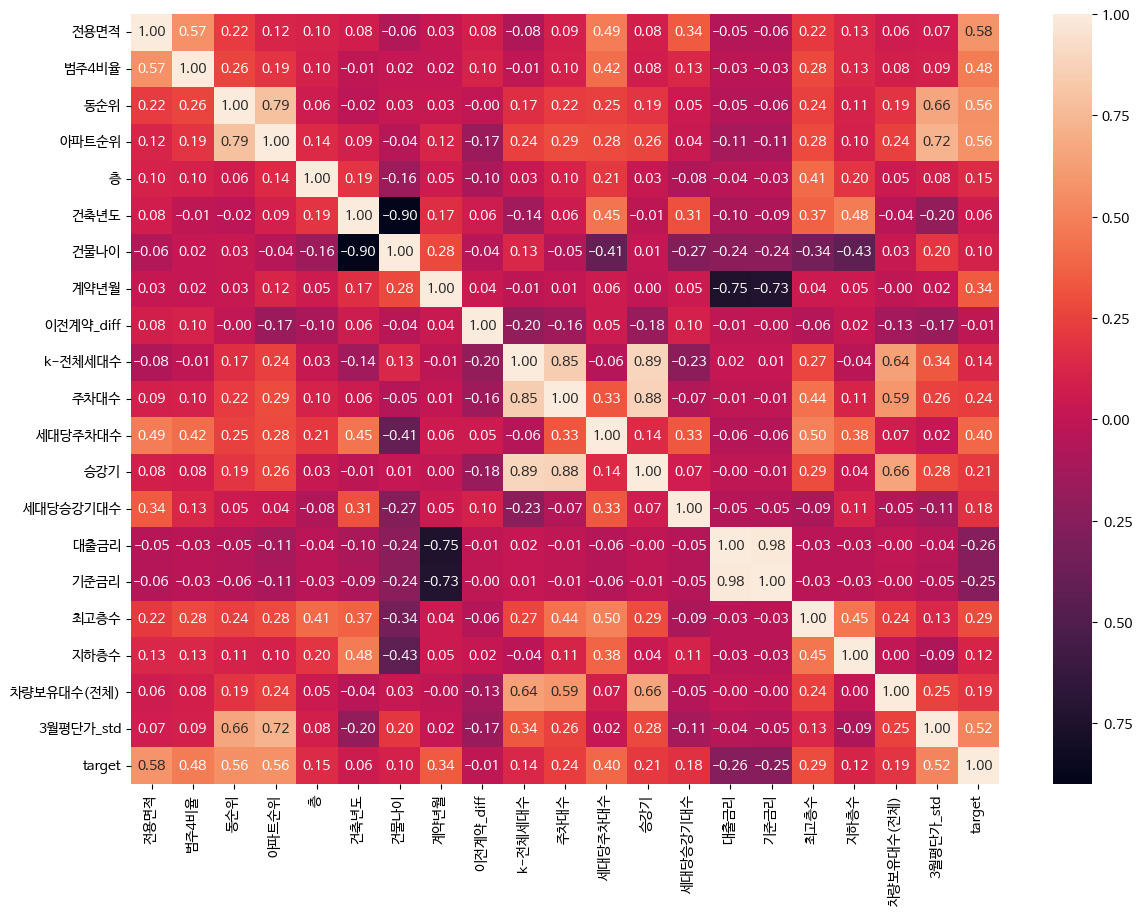

In [49]:
plt.figure(figsize=(14, 10))
sns.heatmap(data=temp.corr(), annot=True, fmt=".2f")
plt.show()

In [45]:
ㅎㄷㅁㅈ

NameError: name 'ᄒᄃᄆᄌ' is not defined

### 1 거래가와 전용면적의 분포

<Axes: xlabel='target', ylabel='Count'>

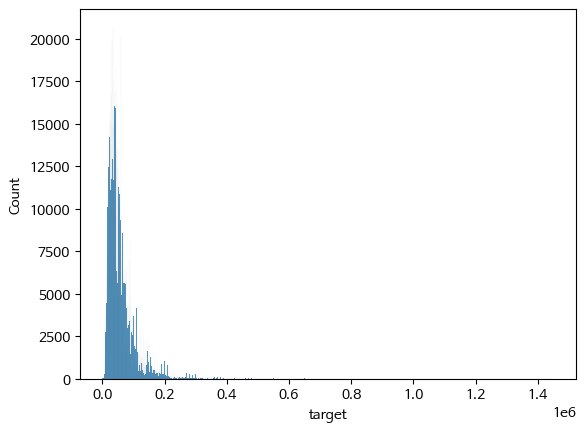

In [ ]:
sns.histplot(data=df_eda, x='target')

- 상당히 오른쪽으로 skewness한 분포를 보입니다.


<Axes: xlabel='전용면적', ylabel='Count'>

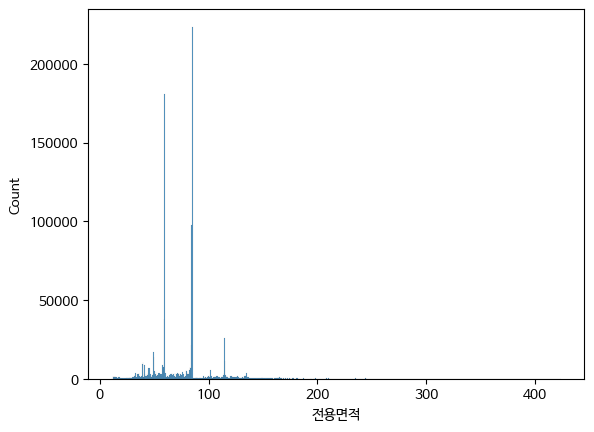

In [ ]:
sns.histplot(data=df_eda, x='전용면적')

- 상당히 오른쪽으로 skewness한 분포를 보입니다.


### 2 전용면적

<Axes: xlabel='전용면적범주', ylabel='count'>

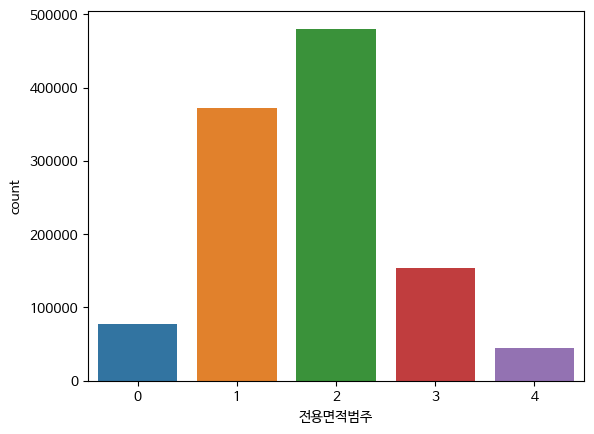

In [ ]:
sns.countplot(data=df_eda, x='전용면적범주')

- 전용면적범주: 40미만-소형, 40~60-중소형, 60~85-중형, 85~135-중대형, 135초과-대형 순으로 0~4 입니다.


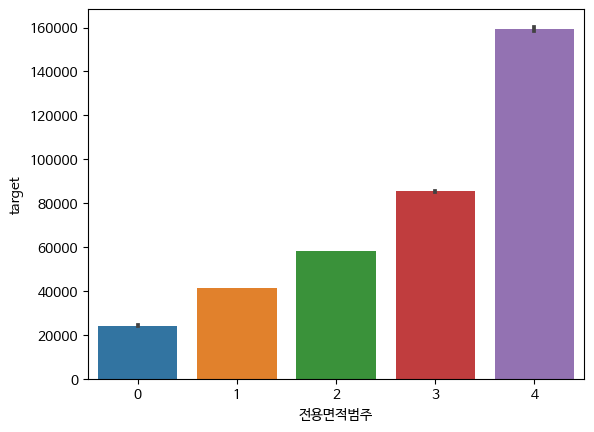

In [ ]:
sns.barplot(data=df_eda, x='전용면적범주', y='target')
plt.show()

- 당연하게도 전용면적이 클수록 집값은 증가합니다.


<Axes: xlabel='전용면적범주', ylabel='count'>

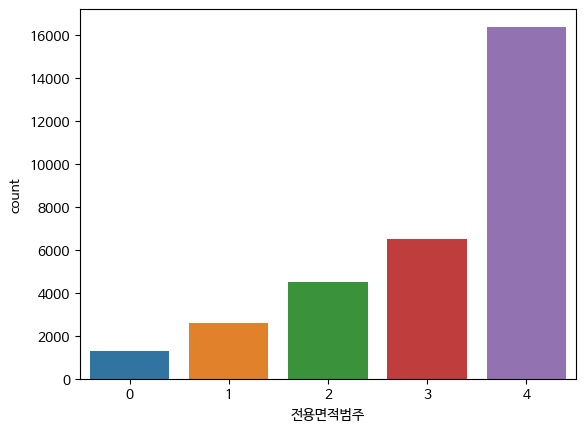

In [ ]:
temp = df_eda[df_eda['전용면적'] > 200]
temp = df_eda[df_eda['풀아파트명'].isin(temp['풀아파트명'])]
sns.countplot(data=temp, x='전용면적범주')

- 상당히 높은 전용면적의 세대가 포함된 아파트의 경우 대체로 전용면적이 높은 세대의 비율이 높습니다.
- 아파트별로 전용면적범주의 비율을 구하면 고급 아파트를 분류할 수 있을지도 모르겠습니다.

### 3 층

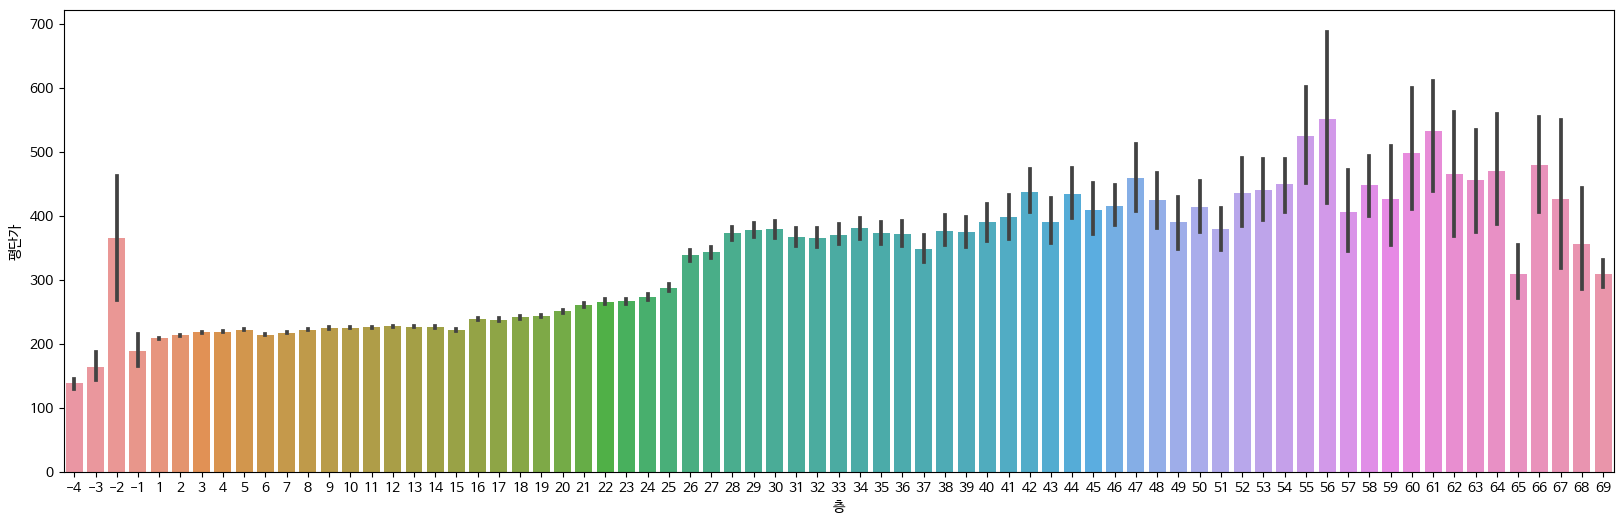

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=df_eda, x='층', y='평단가')
plt.show()

- 층이 높아질수록 평단가가 증가합니다.
- 층수가 어느정도 높아지면 무작위한 값을 보입니다.
- -2층의 이상치는 상당히 가격이 높은 아파트인 한남더힐이 포함돼 크게 나타나는 것으로 보입니다.

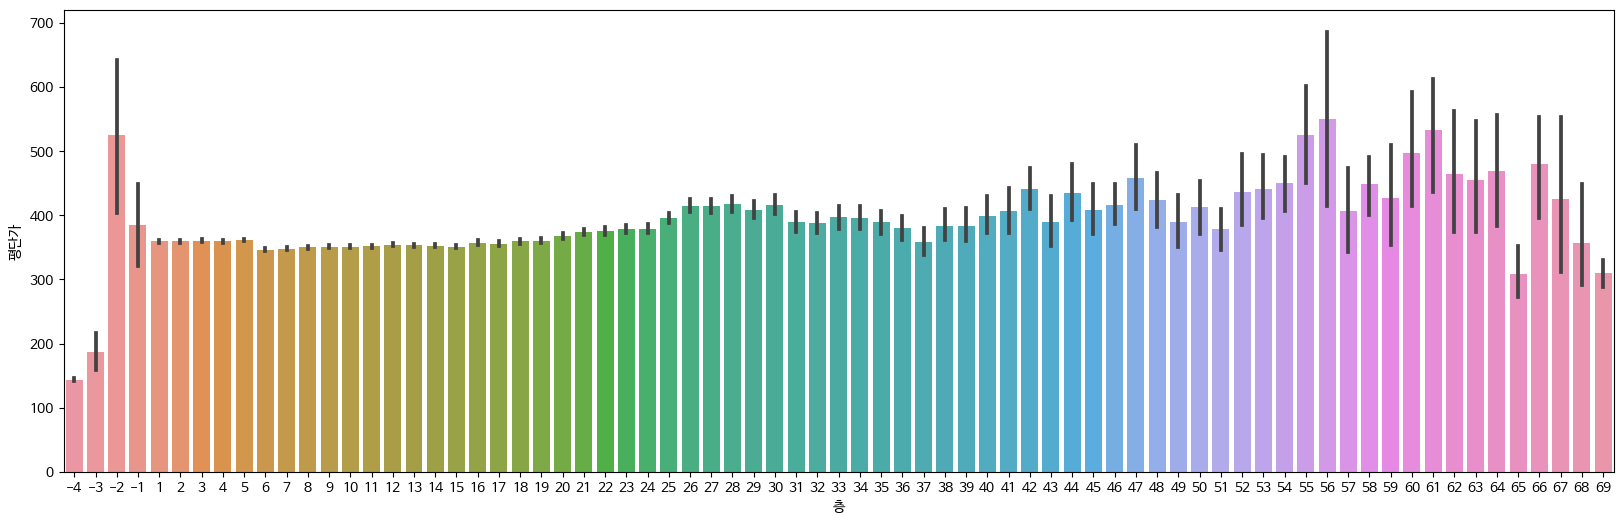

In [ ]:
temp = concat_select[concat_select['target'] >= concat_select['target'].quantile(0.7)]

plt.figure(figsize=(20, 6))
sns.barplot(data=temp, x='층', y='평단가')
plt.show()

- 가격이 높은 아파트들은 층수에 크게 영향을 받지 않는 것 같습니다.
- 층수 컬럼은 일반적인 가격대의 아파트들을 예측하는데 도움이 될 것 같습니다.

### 4 구, 동, 아파트

In [ ]:
temp = df_eda.groupby('동')['평단가'].mean().reset_index()
temp = temp.sort_values(by='평단가')

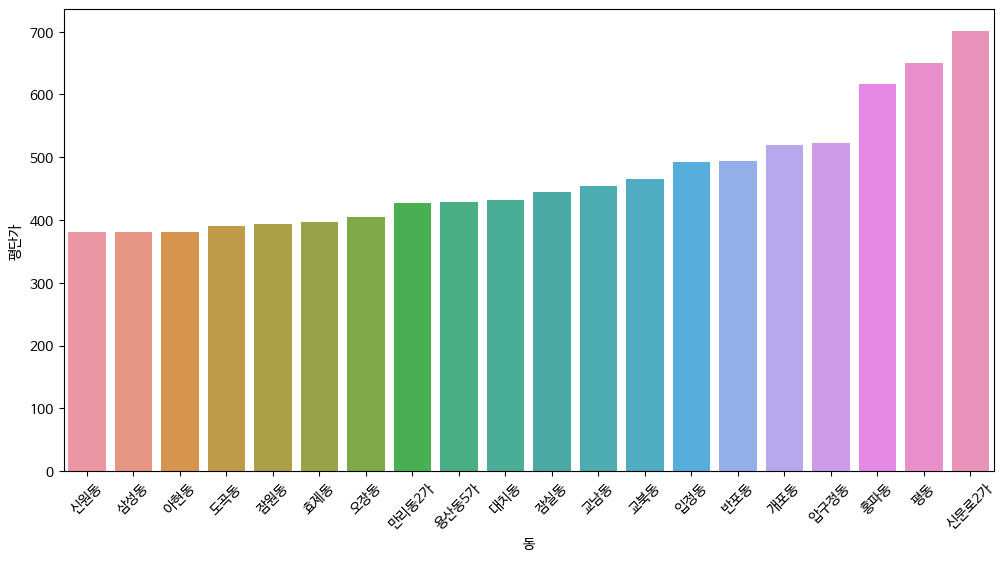

In [ ]:
# 평단가가 높은 동 TOP 20 
plt.figure(figsize=(12, 6))
sns.barplot(data=temp.tail(20), x='동', y='평단가')
plt.xticks(rotation=45)
plt.show()

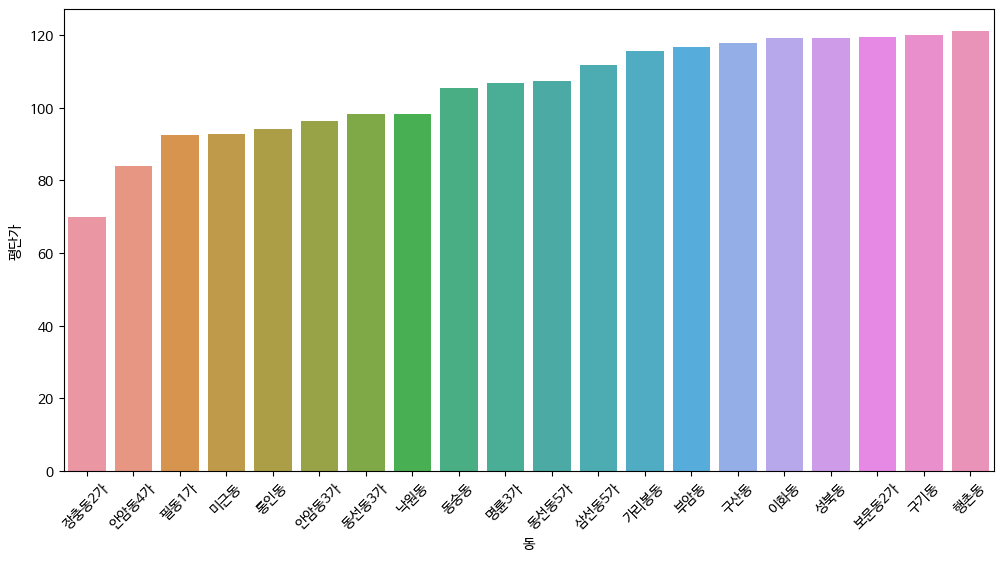

In [ ]:
# 평단가가 낮은 동 TOP 20 
plt.figure(figsize=(12, 6))
sns.barplot(data=temp.head(20), x='동', y='평단가')
plt.xticks(rotation=45)
plt.show()

In [ ]:
temp = df_eda.groupby('구')['평단가'].mean().reset_index()
temp = temp.sort_values(by='평단가')

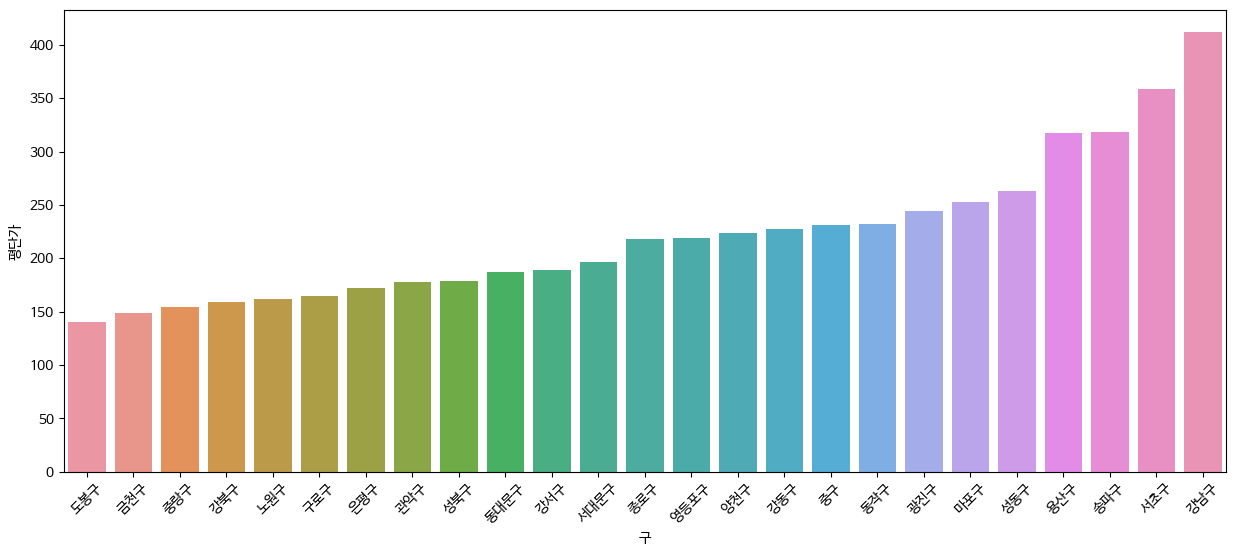

In [ ]:
# 평단가가 높은 구
plt.figure(figsize=(15, 6))
sns.barplot(data=temp, x='구', y='평단가')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_eda['동아파트'] = df_eda['동']+ " " + df_eda['아파트명']

In [ ]:
temp = df_eda.groupby('풀아파트명').agg({'평단가':'mean', '동아파트': 'first'}).reset_index()

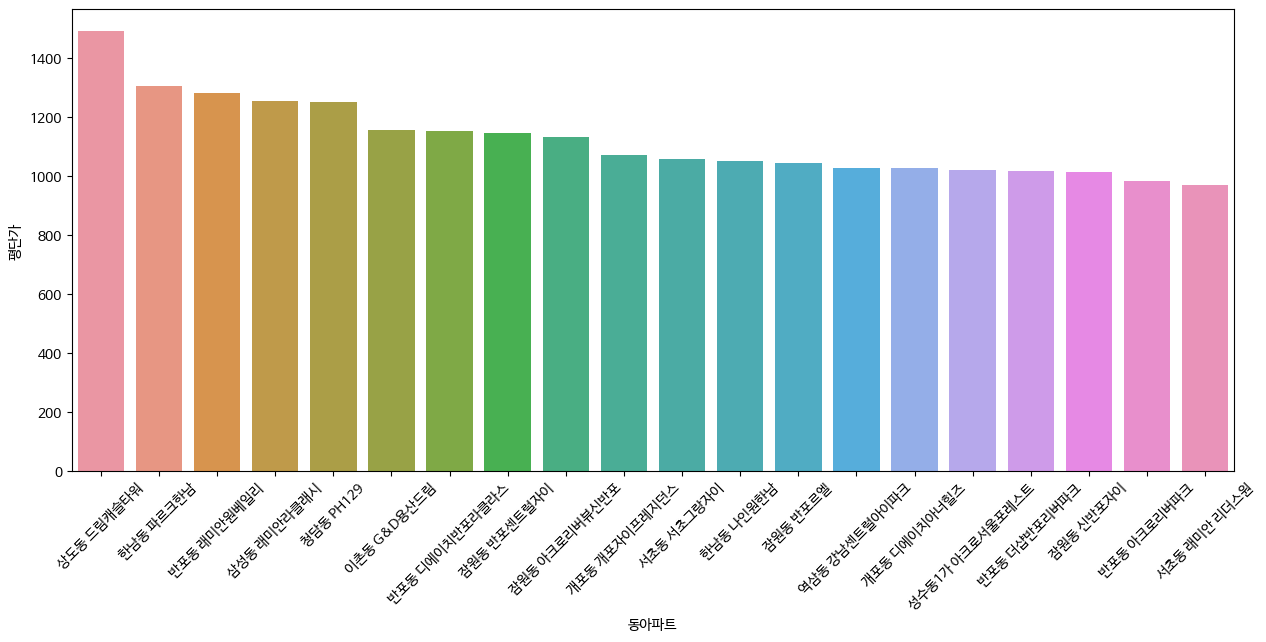

In [ ]:
# 평단가가 높은 아파트 TOP 20 
plt.figure(figsize=(15, 6))
sns.barplot(data=temp.sort_values(by='평단가', ascending=False).head(20), x='동아파트', y='평단가')
plt.xticks(rotation=45)
plt.show()

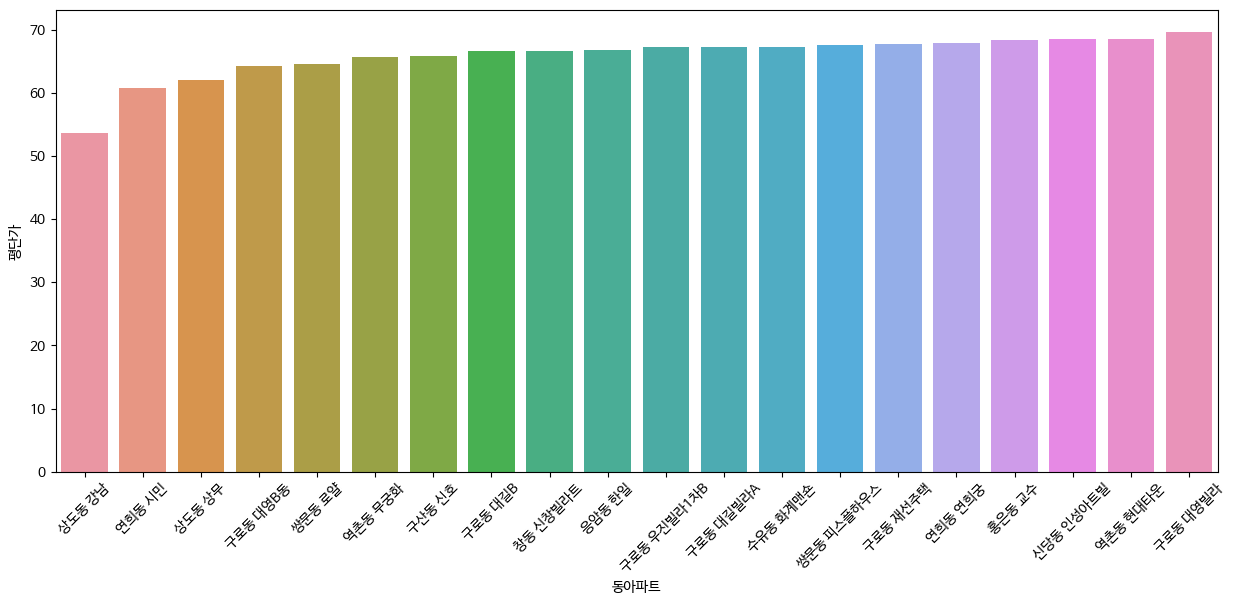

In [ ]:
# 평단가가 낮은 아파트 TOP 20 
plt.figure(figsize=(15, 6))
sns.barplot(data=temp.sort_values(by='평단가').head(20), x='동아파트', y='평단가')
plt.xticks(rotation=45)
plt.show()

- 구, 동, 아파트별로 평단가 랭킹을 구해 라벨링해주면 간접적으로 target값을 반영해줄 수 있을 것 같습니다.

### 5 세대당주차대수, 세대당승강기갯수

In [ ]:
bins = np.arange(0, 12000, 100)
labels = np.arange(0, 12000, 100)[:-1]
df_eda['주차대수범주'] = pd.cut(df_eda['주차대수'], bins=bins, labels=labels)

<Axes: xlabel='주차대수범주', ylabel='target'>

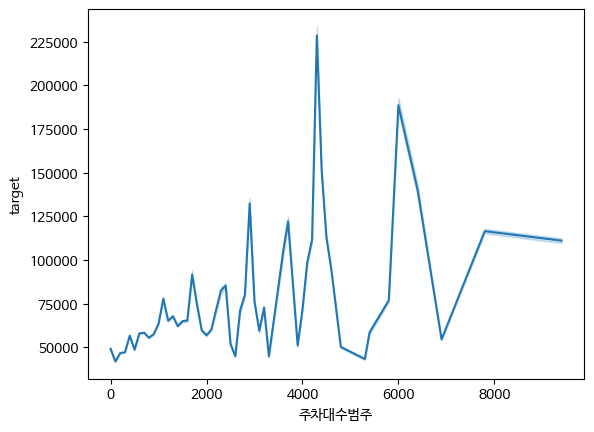

In [ ]:
sns.lineplot(data=df_eda, x='주차대수범주', y='target')

In [ ]:
bins = np.arange(0, 5, 0.1)
labels = np.arange(0, 5, 0.1)[:-1]
df_eda['세대당주차대수범주'] = pd.cut(df_eda['세대당주차대수'], bins=bins, labels=labels)

<Axes: xlabel='세대당주차대수범주', ylabel='target'>

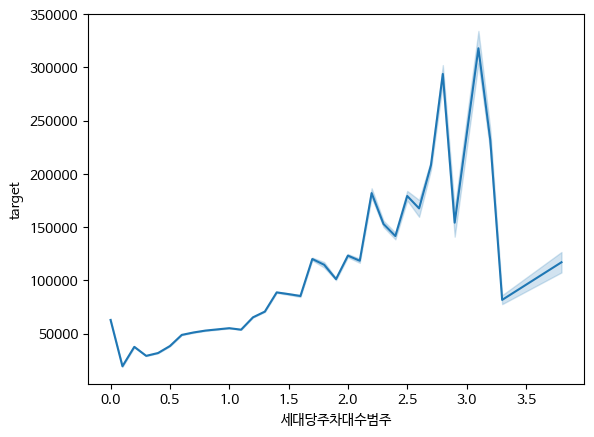

In [ ]:
# 거래가와 
sns.lineplot(data=df_eda, x='세대당주차대수범주', y='target')

- 확실히 그냥 주차대수 보다 세대당주차대수가 거래가와 상관관계가 있어보입니다.

In [ ]:
bins = np.arange(0, 300, 10)
labels = np.arange(0, 300, 10)[:-1]
df_eda['승강기범주'] = pd.cut(df_eda['승강기'], bins=bins, labels=labels)

<Axes: xlabel='승강기', ylabel='target'>

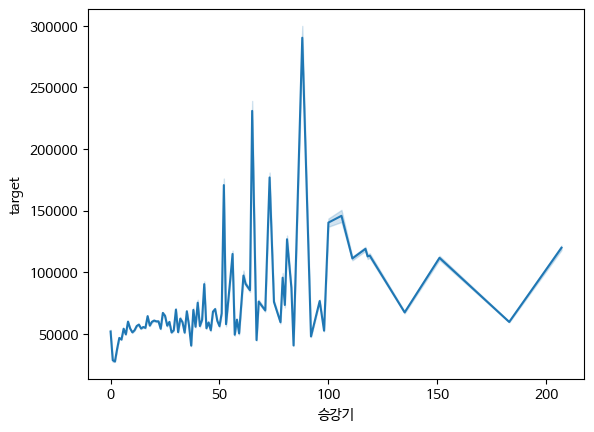

In [ ]:
sns.lineplot(data=df_eda, x='승강기', y='target')

In [ ]:
bins = np.arange(0, 0.2, 0.01)
labels = np.arange(0, 0.2, 0.01)[:-1]
df_eda['세대당승강기대수범주'] = pd.cut(df_eda['세대당승강기대수'], bins=bins, labels=labels)

<Axes: xlabel='세대당승강기대수범주', ylabel='target'>

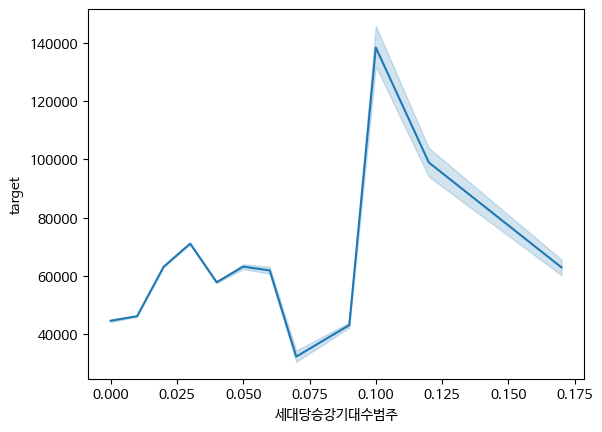

In [ ]:
# 거래가와 
sns.lineplot(data=df_eda, x='세대당승강기대수범주', y='target')

- 승강기 갯수는 거래가와 명확한 상관관계가 나타나는 것 같지는 않습니다.

### 6 건축년도

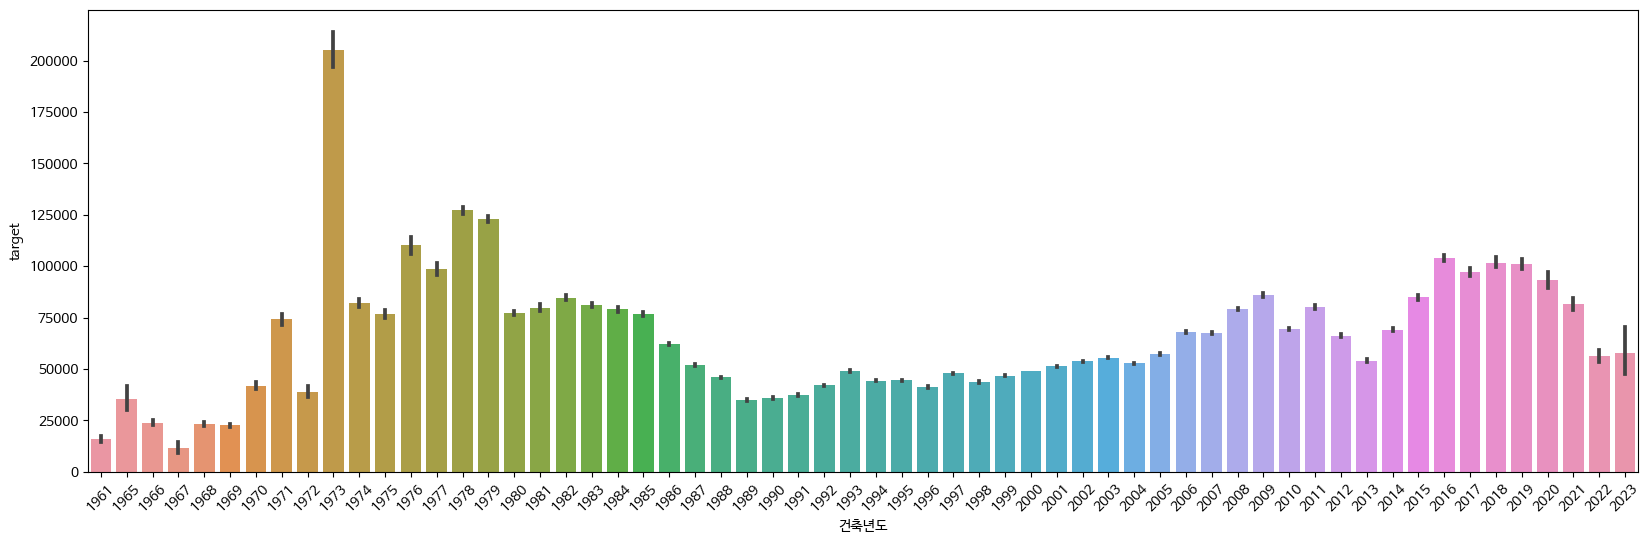

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=df_eda, x='건축년도', y='target')
plt.xticks(rotation=45)
plt.show()

In [ ]:
temp = df_eda[df_eda['건축년도'] == 1973] 
temp = temp[temp['target'] > 200000]

In [ ]:
temp[['풀아파트명', 'target']]

,풀아파트명,target
57877,서울특별시 서초구 반포동 반포주공1단지,240000.0
57878,서울특별시 서초구 반포동 반포주공1단지,340000.0
57879,서울특별시 서초구 반포동 반포주공1단지,380000.0
57880,서울특별시 서초구 반포동 반포주공1단지,285000.0
57881,서울특별시 서초구 반포동 반포주공1단지,337000.0
...,...,...
990279,서울특별시 서초구 반포동 반포주공1단지,209200.0
990284,서울특별시 서초구 반포동 반포주공1단지,225000.0
990286,서울특별시 서초구 반포동 반포주공1단지,218500.0
990287,서울특별시 서초구 반포동 반포주공1단지,210000.0


- 1973년에 반포주공1단지 아파트의 매물이 그 당시 상당히 비싼가격으로 매우 많이 거래가 이루어졌습니다.

In [ ]:
temp = df_eda[df_eda['건축년도'] == 1973] 
temp = temp.groupby('구')['target'].mean().reset_index()

<Axes: xlabel='구', ylabel='target'>

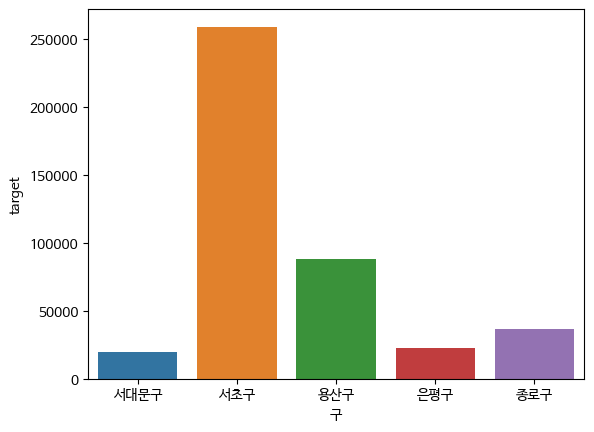

In [ ]:
sns.barplot(data=temp, x='구', y='target')

In [ ]:
temp = df_eda[df_eda['건축년도'] == 1976] 
temp = temp.groupby('구')['target'].mean().reset_index()

<Axes: xlabel='구', ylabel='target'>

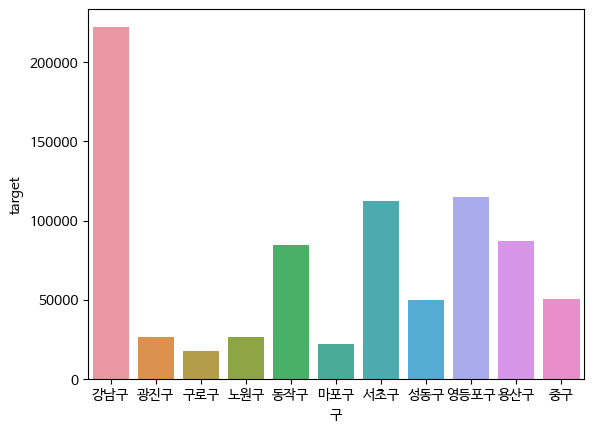

In [ ]:
sns.barplot(data=temp, x='구', y='target')

- 1973년도를 기점으로 서초구, 강남구, 용산구 등등 강남권 지역들의 집값이 크게 뛰기 시작합니다.
- 건축년도 컬럼을 이용해서 해당 건물이 계약일기준 얼마나 오래됐는지 판단할 수 있을 것 같습니다.

### 7 금리

In [ ]:
df_eda[['풀아파트명', '대출금리', '기준금리', 'target']].corr()

,대출금리,기준금리,target
대출금리,1.000000,0.982867,-0.259294
기준금리,0.982867,1.000000,-0.251248
target,-0.259294,-0.251248,1.000000


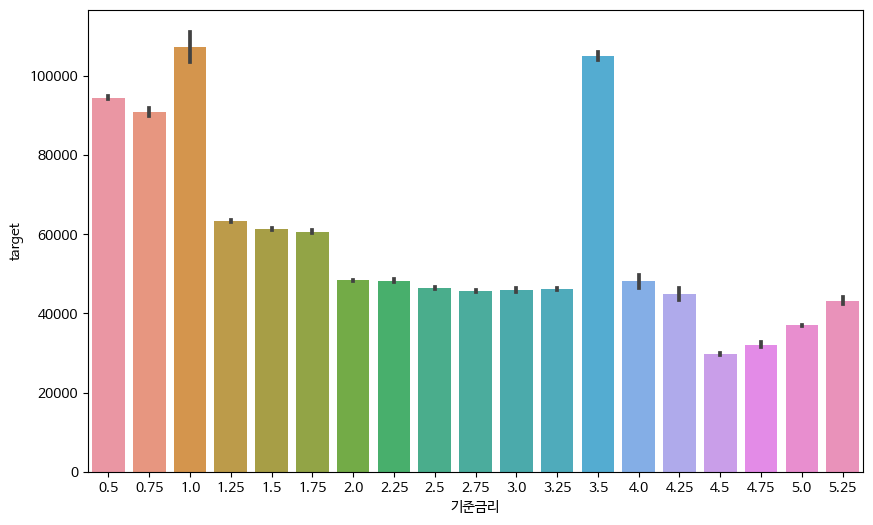

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_eda, x='기준금리', y='target')
plt.show()

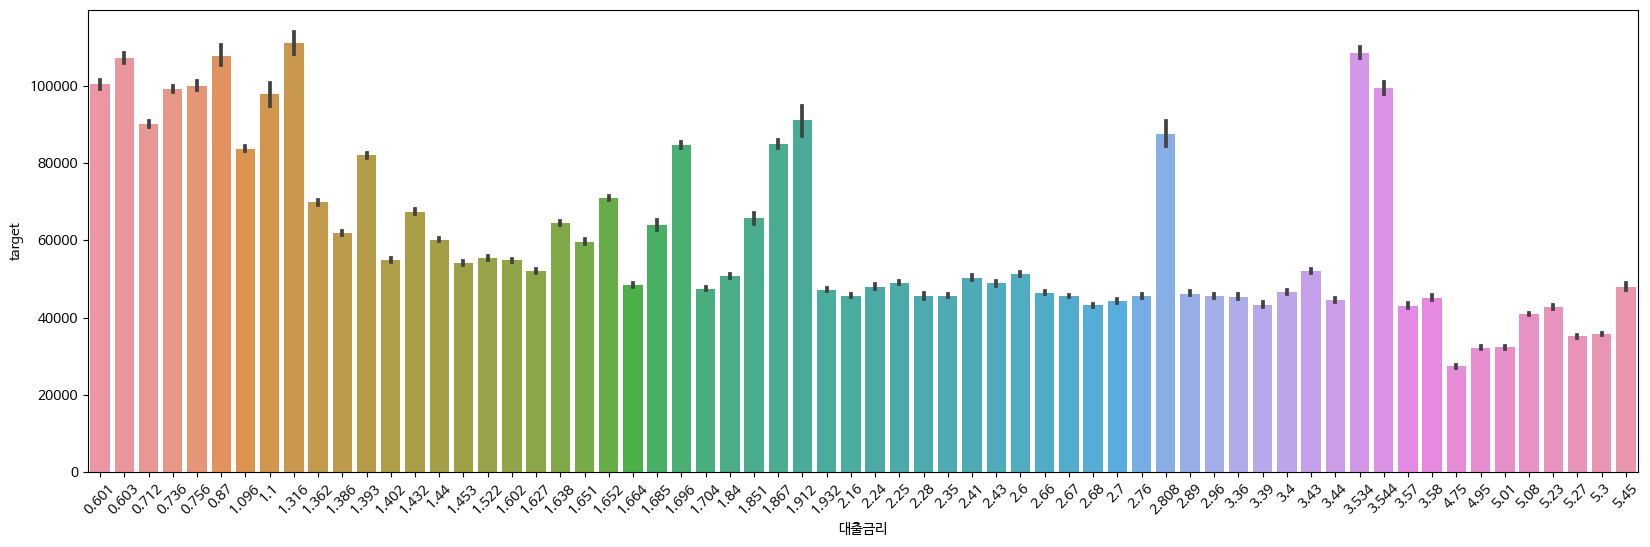

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=df_eda, x='대출금리', y='target')
plt.xticks(rotation=45)
plt.show()

- 금리가 높을수록 집값이 떨어진다는 도메인 지식과 어느정도 부합하는 결과를 보여줍니다.

### 8 계약일

In [ ]:
df_eda[['풀아파트명', '계약년월일', '계약년월', '계약경과일', '이전계약_diff', 'target']].corr()

,계약년월,계약경과일,이전계약_diff,target
계약년월,1.000000,-0.998360,0.042057,0.344665
계약경과일,-0.998360,1.000000,-0.041930,-0.346514
이전계약_diff,0.042057,-0.041930,1.000000,-0.005495
target,0.344665,-0.346514,-0.005495,1.000000


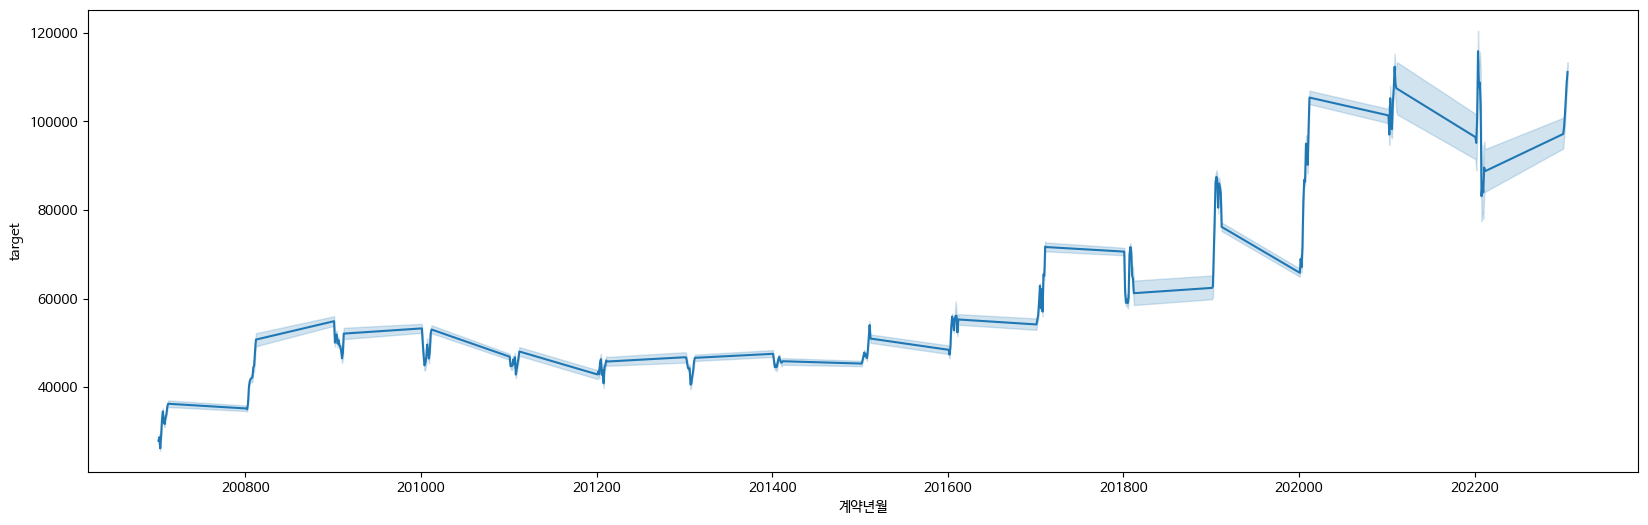

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_eda, x='계약년월', y='target')
plt.show()

- 아파트가격은 계약일이 최근일수록 증가하는 경향을 보입니다.
- 또한 매년 초마다 아파트가격이 급증하거나 급감하는 경향을 보이는데 이는 부동산 정책의 영향이나 정부에서 아파트 실거래가는 공개하는 공시주기가 연관이 있을 수도 있을 것 같습니다.

<Axes: xlabel='이전계약_diff', ylabel='target'>

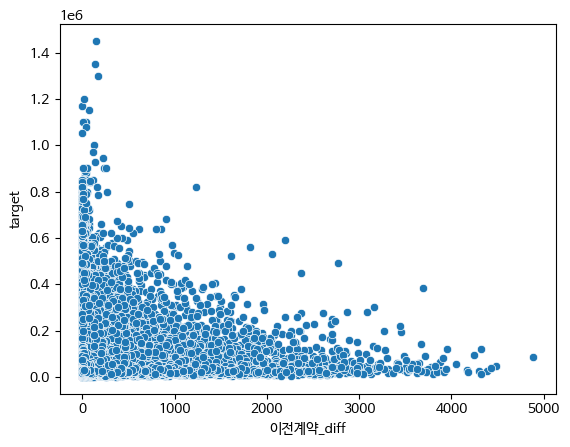

In [ ]:
sns.scatterplot(data=df_eda, x='이전계약_diff', y='target')

- 이전계약_diff컬럼은 시군구 + 아파트명별로 이전계약과 현재계약의 차이를 나타내는 컬럼입니다.
- 그래프의 모양이 어떠한 패턴을 가지고 있는 것처럼 보입니다.
- 부동산 거래 데이터 특성상 이전 거래에 영향을 많이 받기 때문에 이전 거래와의 일수의 차이로 간접적으로 이전 거래의 영향을 나타낼 수 있다고 생각했습니다.

In [ ]:
temp = df_eda[df_eda['이전계약_diff'] > 365*7]
temp = temp.sort_values(by='target', ascending=False)

In [ ]:
temp[['풀아파트명', '이전계약_diff', 'k-전체세대수', '계약년월일', '건축년도', '전용면적', 'target', '아파트거래횟수5']].sample(10)

,풀아파트명,이전계약_diff,k-전체세대수,계약년월일,건축년도,전용면적,target,아파트거래횟수5
215280,서울특별시 서대문구 홍제동 경일,3308.0,NaN,2023-03-29,2004,74.31,36000.0,1.0
2893,서울특별시 강남구 삼성동 노블테라스,2682.0,NaN,2018-09-12,2003,209.86,165000.0,1.0
434135,서울특별시 양천구 신정동 재훈,3945.0,NaN,2018-12-26,2002,81.10,34000.0,1.0
497231,서울특별시 마포구 공덕동 효창그린빌라트,3224.0,NaN,2016-11-04,1996,163.00,60000.0,4.0
519592,서울특별시 송파구 마천동 기영,3196.0,NaN,2017-05-30,1998,84.33,43500.0,10.0
69711,서울특별시 성북구 종암동 동진,3141.0,NaN,2017-11-29,1992,104.86,40000.0,7.0
506974,서울특별시 서초구 서초동 서초대림빌라트,3669.0,NaN,2017-07-20,2004,206.27,144000.0,4.0
649353,서울특별시 강남구 삼성동 삼성동신영지웰,2605.0,NaN,2015-03-03,2005,117.77,84000.0,2.0
750926,서울특별시 용산구 이촌동 강서,2744.0,NaN,2015-09-09,1972,57.95,38000.0,9.0
26142,서울특별시 구로구 구로동 일심빌리지,3129.0,NaN,2018-01-12,1997,46.32,11500.0,3.0


- 오랫동안 계약이 없는 매물은 재개발이나 재건축 아파트일 것이라는 가설이었지만 EDA 결과 비교적 세대수가 적고 거래수가 적은 혹은 인기가 없는? 매물에 가까운 것 같습니다.

### 9 평단가의 분산

In [ ]:
df_eda[['풀아파트명', '3월평단가_std', 'target']].corr()

,3월평단가_std,target
3월평단가_std,1.0000,0.5167
target,0.5167,1.0000


In [ ]:
temp = df_eda[df_eda['target'] > df_eda['target'].quantile(0.7)]

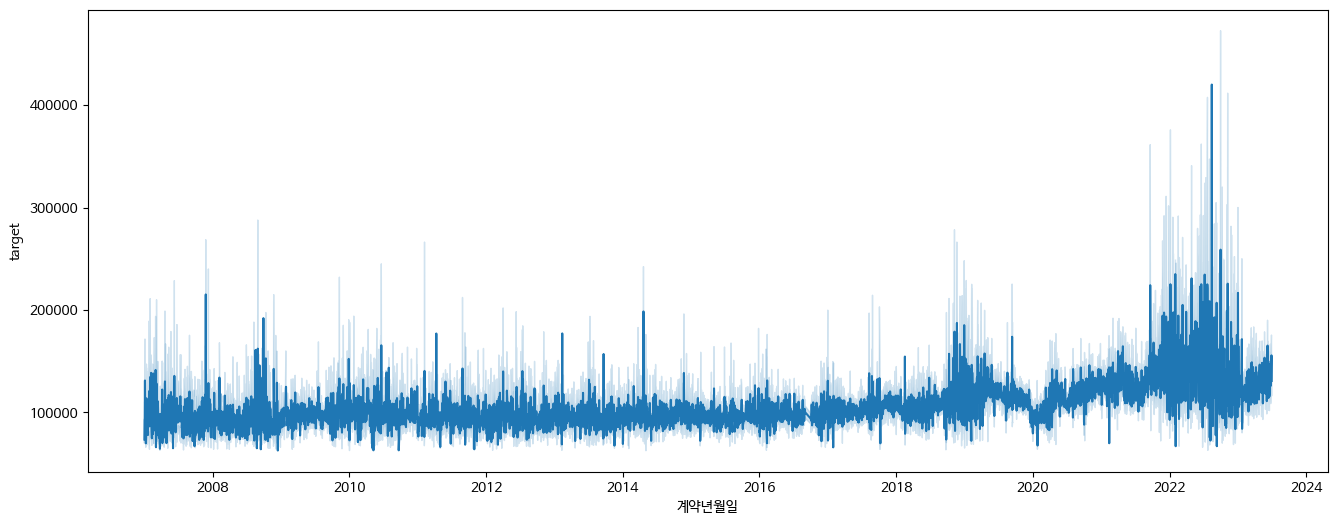

In [ ]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=temp, x='계약년월일', y='target')
plt.show()

In [ ]:
temp = df_eda[df_eda['target'] < df_eda['target'].quantile(0.5)]

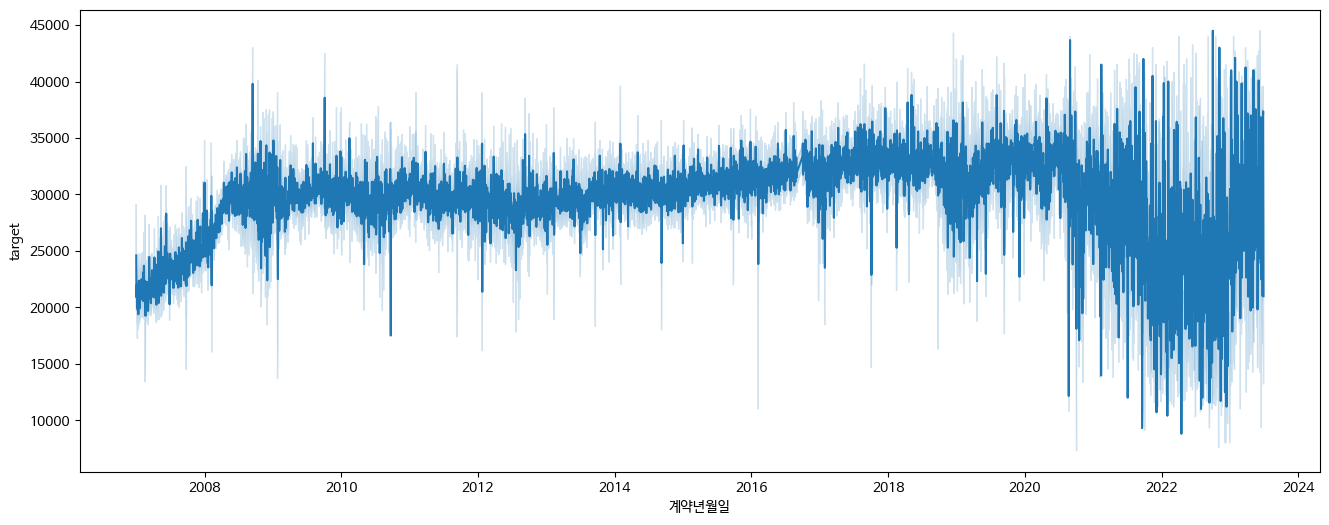

In [ ]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=temp, x='계약년월일', y='target')
plt.show()

- 당연하게도 가격이 높은 매물이 분산이 더 큰것을 확인할 수 있습니다.
- 분산을 잘 활용하면 가격이 높은 매물과 낮은 매물을 구별할 수도 있을 것 같습니다.